In [37]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

In [38]:
# Model
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input   = torch.nn.Linear(3, 3)
    self.hidden1 = torch.nn.Linear(3, 3)
    self.output  = torch.nn.Linear(3, 1)

  def forward(self, x):
    z = torch.selu(self.input(x))
    z = torch.selu(self.hidden1(z))
    z = torch.relu(self.output(z))
    return z

In [39]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x_data)
    
    # R^2
    SSR = torch.sum(torch.square(pred_Y - testset.y_data))
    SST = torch.sum(torch.square(pred_Y - torch.mean(testset.y_data)))
    r2 = 1 - SSR/SST

    # RMSE
    rmse = torch.sqrt(torch.mean(torch.square(pred_Y - testset.y_data)))
    return r2, rmse

In [40]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [41]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    Tz_k   = np.array(df['room_temp']).reshape(-1,1)[start: end]
    Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
    msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]

    tmp_x = np.concatenate((Tz_k, Tsa_k1, ((msa_k1-400)/600)*(Tsa_k1-Tz_k)), axis=1)
    tmp_y = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]

    self.x_data = torch.tensor(tmp_x, dtype=torch.float32)
    self.y_data = torch.tensor(tmp_y, dtype=torch.float32)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp  = self.x_data[idx]
    outp = self.y_data[idx]
    sample = {'inp':inp, 'outp':outp}
    return sample

# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv'
n_train = 128
train_ds = Data(src_file, start=0,       end=n_train)
test_ds  = Data(src_file, start=n_train, end=1600)

In [42]:
# train model
max_epochs = 30000
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.001)

R2_train   = np.array([])
RMSE_train = np.array([])
R2_test    = np.array([])
RMSE_test  = np.array([])

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X = batch['inp']
        Y = batch['outp']

        optimizer.zero_grad()
        output = net(X)                    # compute the output of the Network
        loss_val = loss_func(output, Y)    # loss function
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1

    net.eval()
    R2_train   = np.append(R2_train, eval(net, train_ds)[0].item())
    RMSE_train = np.append(RMSE_train, eval(net, train_ds)[1].item())
    R2_test    = np.append(R2_test, eval(net, test_ds)[0].item())
    RMSE_test  = np.append(RMSE_test, eval(net, test_ds)[1].item())


    if(epoch%1000==0):
        print("epoch = %5d \t loss = %8.3f \t RMSE = %6.3f \t R2 = %7.5f" % (epoch, loss/count, eval(net, test_ds)[1].item(), eval(net, test_ds)[0].item()))

epoch =     0 	 loss = 5211.388 	 RMSE = 71.655 	 R2 = -0.00072
epoch =  1000 	 loss =    3.378 	 RMSE =  2.511 	 R2 = 0.54191
epoch =  2000 	 loss =    0.627 	 RMSE =  1.089 	 R2 = 0.81398
epoch =  3000 	 loss =    0.028 	 RMSE =  0.220 	 R2 = 0.98696
epoch =  4000 	 loss =    0.012 	 RMSE =  0.120 	 R2 = 0.99580
epoch =  5000 	 loss =    0.007 	 RMSE =  0.085 	 R2 = 0.99788
epoch =  6000 	 loss =    0.006 	 RMSE =  0.084 	 R2 = 0.99795
epoch =  7000 	 loss =    0.006 	 RMSE =  0.084 	 R2 = 0.99791
epoch =  8000 	 loss =    0.006 	 RMSE =  0.084 	 R2 = 0.99793
epoch =  9000 	 loss =    0.006 	 RMSE =  0.083 	 R2 = 0.99795
epoch = 10000 	 loss =    0.006 	 RMSE =  0.083 	 R2 = 0.99795
epoch = 11000 	 loss =    0.006 	 RMSE =  0.083 	 R2 = 0.99796
epoch = 12000 	 loss =    0.006 	 RMSE =  0.083 	 R2 = 0.99796
epoch = 13000 	 loss =    0.006 	 RMSE =  0.083 	 R2 = 0.99796
epoch = 14000 	 loss =    0.006 	 RMSE =  0.083 	 R2 = 0.99796
epoch = 15000 	 loss =    0.006 	 RMSE =  0.083 	 R2 =

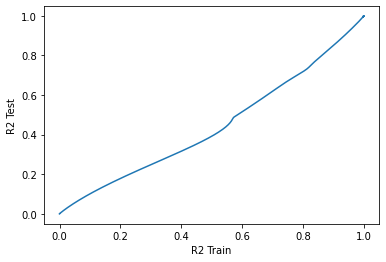

In [43]:
plt.plot(R2_train, R2_test)
plt.xlabel('R2 Train')
plt.ylabel('R2 Test')
plt.show()

In [44]:
def plot(dataset, size):
  with torch.no_grad():
      pred_Y = net(dataset.x_data)

  plt.figure(figsize=size)
  plt.plot(dataset.y_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

RMSE: 0.07599221169948578
R2:   0.998096227645874


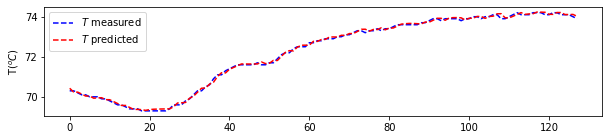

In [45]:
net.eval()
print("RMSE:", eval(net, train_ds)[1].item())
print("R2:  ", eval(net, train_ds)[0].item())
plot(train_ds, (10, 2))

RMSE: 0.07278183102607727
R2:   0.9984375238418579


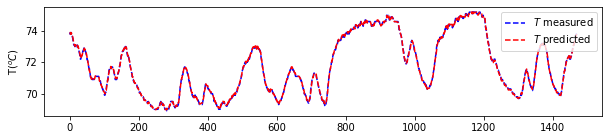

In [46]:
net.eval()
print("RMSE:", eval(net, test_ds)[1].item())
print("R2:  ", eval(net, test_ds)[0].item())
plot(test_ds, (10, 2))

In [47]:
print(np.argmax(R2_test))
print(np.max(R2_test))

29852
0.9984483122825623


In [48]:
# PATH = 'C:/Users/tln229/Downloads/Python/Building/0. Saved models/Tz.pt'
# torch.save(net, PATH)